<a href="https://colab.research.google.com/github/iyaja/stylegan-encoder/blob/master/notebooks/GoT_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/iyaja/stylegan-encoder.git
import os
os.chdir("stylegan-encoder")

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.25 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

OSError: ignored

In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img
    #return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
os.mkdir('raw_images')
os.mkdir('aligned_images')
os.mkdir('latent_representations')
os.mkdir('generated_images')
os.mkdir('results')

In [0]:
# Loading already learned representations
jon = np.load('latent_representations/jon.npy')
tyrion = np.load('latent_representations/tyrion.npy')
daenerys = np.load('latent_representations/daenerys.npy')
drogo = np.load('latent_representations/drogo.npy')
bran = np.load('latent_representations/bran.npy')
cersei = np.load('latent_representations/cersei.npy')
jaime = np.load('latent_representations/jaime.npy')
theon = np.load('latent_representations/theon.npy')
night_king_1 = np.load('latent_representations/night_king_1.npy')
night_king_2 = np.load('latent_representations/night_king_2.npy')


In [0]:
# Of course you can learn your own vectors using two scripts

# 1) Extract and align faces from images
# !python align_images.py raw_images/ aligned_images/

# 2) Find latent representation of aligned images
# !python encode_images.py aligned_images/ generated_images/ latent_representations/

In [0]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

# In general it's possible to find directions of almost any face attributes: position, hair style or color ... 
# Additional scripts for doing so will be realised soon

In [0]:
drogo = np.load('latent_representations/this_game_of_thrones_theory_suggests_that_khal_drogo_might_return_in_season_8_1542879406_01.npy')
generate_image(drogo)

In [0]:
theon = np.load('latent_representations/theon.npy')
bran = np.load('latent_representations/bran.npy')
cersei = np.load('latent_representations/cersei.npy')
night_king = np.load('latent_representations/night_king.npy')
jaime = np.load('latent_representations/jaime.npy')

# Smile transformation

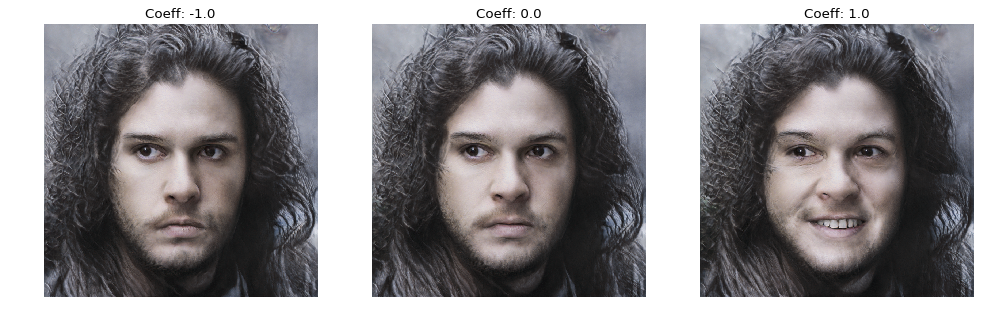

In [0]:
move_and_show(jon, smile_direction, [-1, 0, 1])

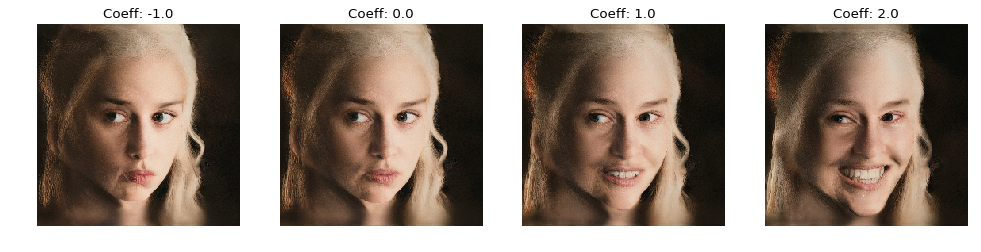

In [0]:
move_and_show(daenerys, smile_direction, [-1, 0, 1, 2])

# Gender transformation

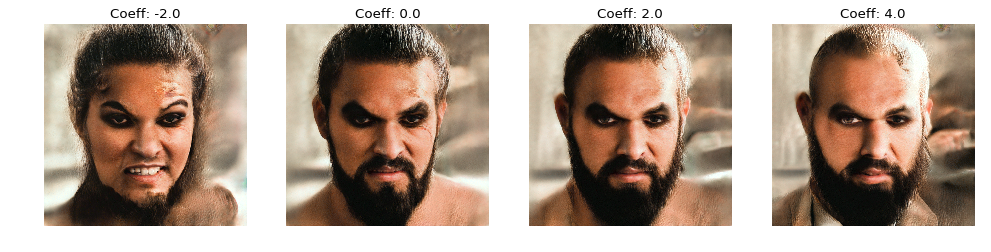

In [0]:
move_and_show(drogo, gender_direction, [-2, 0, 2,4])

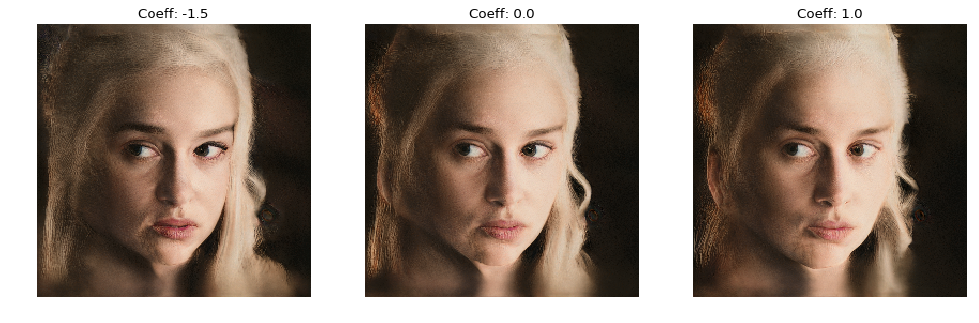

In [0]:
move_and_show(daenerys, gender_direction, [-1.5, 0, 1])

# Age transformation

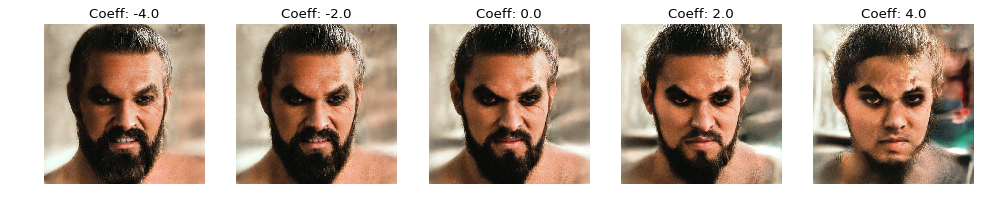

In [0]:
move_and_show(drogo, age_direction, [-4,-2, 0, 2,4])

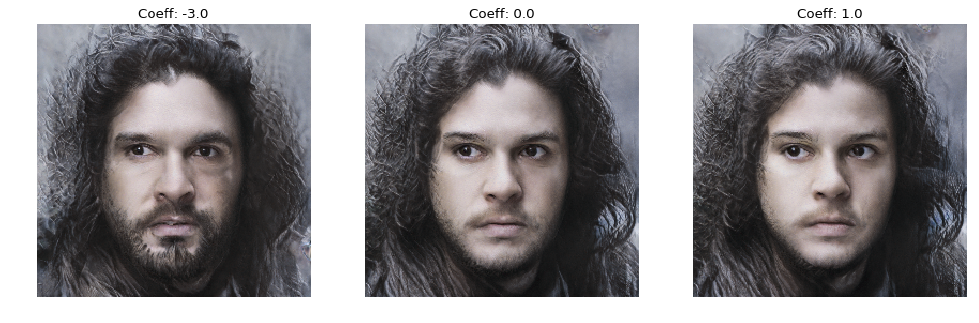

In [0]:
# try it yourself!
move_and_show(jon, age_direction, [-3, 0, 1])

In [0]:
alpha = 0.5

baby = (alpha*jon) + ((1-alpha)*daenerys)
generate_image(baby)

NameError: ignored

#Character Fusion

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
    print(png)
    #src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    #dst_dlatents = Gs.components.mapping.run(dst_latents, None)
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h * (len(dst_dlatents) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)
    return canvas.resize((512,512))

results/style-mixing.png


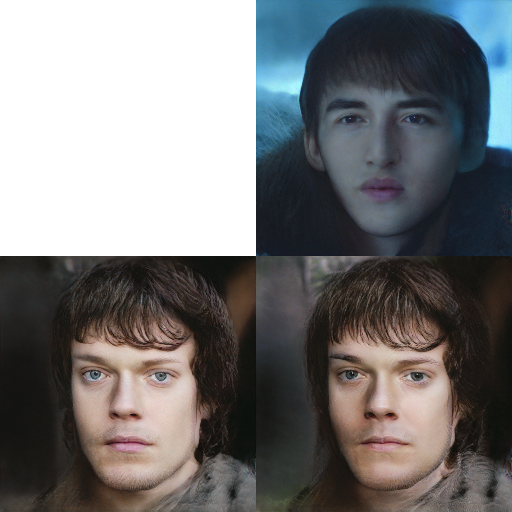

In [0]:
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)
_Gs_cache = dict()

draw_style_mixing_figure(os.path.join(config.result_dir, 'style-mixing.png'), Gs_network, w=1024, h=1024, src_dlatents=bran.reshape((1, 18, 512)), dst_dlatents=theon.reshape((1, 18, 512)), style_ranges=[range(8,10)])

In [0]:
alpha = 0.4
generate_image(((alpha)*jon)+((1-alpha)*daenerys))

#Interpolations

In [0]:
import dnnlib.tflib as tflib
import math
import moviepy.editor
from numpy import linalg
import numpy as np
import pickle

def main():
    tflib.init_tf()
    #_G, _D, Gs = pickle.load(open("results/02051-sgan-faces-2gpu/network-snapshot-021980.pkl", "rb"))

    rnd = np.random
    latents_a = rnd.randn(1, Gs.input_shape[1])
    latents_b = rnd.randn(1, Gs.input_shape[1])
    latents_c = rnd.randn(1, Gs.input_shape[1])

    def circ_generator(latents_interpolate):
        radius = 40.0

        latents_axis_x = (latents_a - latents_b).flatten() / linalg.norm(latents_a - latents_b)
        latents_axis_y = (latents_a - latents_c).flatten() / linalg.norm(latents_a - latents_c)

        latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
        latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

        latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
        return latents

    def mse(x, y):
        return (np.square(x - y)).mean()

    def generate_from_generator_adaptive(gen_func):
        max_step = 1.0
        current_pos = 0.0

        change_min = 10.0
        change_max = 11.0

        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

        current_latent = gen_func(current_pos)
        current_image = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
        array_list = []

        video_length = 1.0
        while(current_pos < video_length):
            array_list.append(current_image)

            lower = current_pos
            upper = current_pos + max_step
            current_pos = (upper + lower) / 2.0

            current_latent = gen_func(current_pos)
            current_image = images = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
            current_mse = mse(array_list[-1], current_image)

            while current_mse < change_min or current_mse > change_max:
                if current_mse < change_min:
                    lower = current_pos
                    current_pos = (upper + lower) / 2.0

                if current_mse > change_max:
                    upper = current_pos
                    current_pos = (upper + lower) / 2.0


                current_latent = gen_func(current_pos)
                current_image = images = Gs.run(current_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)[0]
                current_mse = mse(array_list[-1], current_image)
            print(current_pos, current_mse)
        return array_list

    frames = generate_from_generator_adaptive(circ_generator)
    frames = moviepy.editor.ImageSequenceClip(frames, fps=30)

    # Generate video.
    mp4_file = 'results/circular.mp4'
    mp4_codec = 'libx264'
    mp4_bitrate = '3M'
    mp4_fps = 20

    frames.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)


main()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Error while fetching file: The read operation timed out.
Error while fetching file: The read operation timed out.
Error while fetching file: The read operation timed out.
Error while fetching file: The read operation timed out.


OSError: ignored